In [1]:
%reset -f

In [2]:
import os
import numpy as np
from scipy import interpolate
import scipy.io
import Rbeast as rb
from SLM_tools import *
from scipy.io import savemat
import pickle
import re
import time

In [3]:
top_dir = r"C:\Users\User\OneDrive - mail.tau.ac.il\Documents\Final Project\Project2-Omri and Idan\Results" 

pattern = re.compile(
    r"(?P<type>distance|energy)_vec_mu_(?P<mu>[-+]?\d*\.\d+|\d+)_energy_(?P<energy>[-+]?\d*\.\d+|\d+)_run_num_(?P<run_num>\d+)_total_num_target_\d+\.mat"
)

distance_paths = []
energy_paths = []
seen_distance_paths = set()
seen_energy_paths = set()
mu = 1.6
for root, dirs, files in os.walk(top_dir):
    for file in files:
        match = pattern.match(file)
        if match:
            file_info = match.groupdict()
            if file_info['mu'] == str(mu):
                full_path = os.path.join(root, file)
                if file_info['type'] == 'distance':
                    if full_path not in seen_distance_paths:
                        distance_paths.append(full_path)
                        seen_distance_paths.add(full_path)
                elif file_info['type'] == 'energy':
                    if full_path not in seen_energy_paths:
                        energy_paths.append(full_path)
                        seen_energy_paths.add(full_path)


In [4]:
C = []
downsampling_factor = 1000
n_components = 3
features_extracted = 0
total_runtime = 0
files_with_assembly = 0
total_data_files = len(distance_paths)
log = []
mu = 1.6
counters = {"load":[],"extraction":[],"segmentation":[],"pca":None,"extracted_features":[]}
for i, (energy_path, distance_path) in enumerate(zip(energy_paths, distance_paths)):
    start1 = time.time()
    distance_data = scipy.io.loadmat(distance_path)['foo']
    energy_data = scipy.io.loadmat(energy_path)['foo'].T
    energy_data, distance_data, time_vec = SLM_tools.downsample(energy_data, distance_data,downsampling_factor)
    loading_time = round(time.time() - start1,3)
    log1 = f"\nfile {i+1}/{len(energy_paths)}  loaded: {os.path.relpath(energy_path,top_dir)} Loading time: {loading_time} seconds"
    print(log1)
    log.append(log1)
    counters["load"].append(loading_time)
    start2 = time.time()
    o, cp, mean_trend = SLM_tools.beast(energy_data)
    segmentation_time = round(time.time() - start2,3)
    log2 = f"\nfinished segmentation(Beast), runtime: {segmentation_time} seconds"
    print(log2)
    log.append(log2)
    counters["segmentation"].append(segmentation_time)
    start3 = time.time()
    A = SLM_tools.segment_data(energy_data, distance_data,mean_trend,cp)
    extraction_time = round(time.time() - start3,3)
    print(f"\nfinished feature extraction, runtime: {extraction_time} seconds")
    counters["extraction"].append(extraction_time)
    print(f"\nAssembly? : {len(A) > 0}")
    if len(A) > 0:
        files_with_assembly += 1
        features_extracted += A[0].shape[0]
        counters["extracted_features"].append(A[0].shape[0])
        log3 = f"\nfiles_with_assembly: {files_with_assembly}/{total_data_files}"
        print(log3)
        log.append(log3)
        log4 = f"\nTotal features_extracted: {features_extracted}"
        print(log4)
        log.append(log4)
    else:
        log5 = f"\nNo Assembly, No features extracted"
        print(log5)
        log.append(log5)
    C.append(A)
    total_runtime += (loading_time + extraction_time + segmentation_time)
log6 = f"\nFinished pre-pca processing,total runtime {total_runtime} for {len(energy_paths)} files"
print(log6)
log.append(log6)
with open(f"C_all_mu_{mu}_v2.pkl", "wb") as f:
    pickle.dump(C, f)
log7 = "\nsaved all processed data"
print(log7)
log.append(log7)
start_pca = time.time()
log8 = f"\nStarting PCA"
print(log8)
log.append(log8)
c_reduced = SLM_tools.post_beast_processing(C)
principal_components, score, latent = SLM_tools.pca(c_reduced,n_components)
a_reduced = SLM_tools.post_pca_processing(score, c_reduced,n_components)
counters["selected_features"] = a_reduced.shape[0]
runtime_pca = round(time.time() - start_pca,3)
counters["pca"] = runtime_pca
total_runtime += runtime_pca
log9 = f"\nFinished PCA runtime {runtime_pca} seconds"
print(log9)
log.append(log9)
savemat(f"a_reduced_all_mu_{mu}_v2.mat", {'a_reduced': a_reduced})
log10 = f"\nsaved all extracted features , total extracted features {features_extracted} total runtime {total_runtime} seconds"
log.append(log10)
log.append("SUMMARY")
log11 = f"\nfiles {total_data_files} \nfiles_with_assembly: {files_with_assembly}/{total_data_files} \nmean extracted features {np.mean(counters['extracted_features'])} \ntotal extracted features {features_extracted} \ntotal_selected_features {counters['selected_features']} \ntotal runtime {total_runtime} seconds \nmean loading time {np.mean(counters['load'])} \nmean segmentation time {np.mean(counters['segmentation'])} \nmean extraction time {np.mean(counters['extraction'])} \nPCA time {counters['pca']}"
log.append(log11)
print(log11)
with open(f"run_log_27_7_mu_{mu}_v2.txt",'w') as f:
    for line in log:
        f.write(line)


file 1/314  loaded: 06_30_2022_10_12_02_mu_0__0_2__2_8_Js__4_0_runs_2\2\11\energy_vec_mu_1.6_energy_4.0_run_num_1_total_num_target_2.mat Loading time: 2.618 seconds


finished segmentation(Beast), runtime: 61.952 seconds

finished feature extraction, runtime: 0.116 seconds

Assembly? : True

files_with_assembly: 1/314

Total features_extracted: 58

file 2/314  loaded: 06_30_2022_10_12_02_mu_0__0_2__2_8_Js__4_0_runs_2\2\11\energy_vec_mu_1.6_energy_4.0_run_num_2_total_num_target_2.mat Loading time: 2.173 seconds


finished segmentation(Beast), runtime: 60.591 seconds

finished feature extraction, runtime: 0.032 seconds

Assembly? : True

files_with_assembly: 2/314

Total features_extracted: 115

file 3/314  loaded: 06_30_2022_10_12_02_mu_0__0_2__2_8_Js__4_0_runs_2\2\12\energy_vec_mu_1.6_energy_4.0_run_num_1_total_num_target_2.mat Loading time: 1.927 seconds


finished segmentation(Beast), runtime: 58.872 seconds

finished feature extraction, runtime: 0.031 seconds

Assembly? : True

fil

In [1]:
import os
import numpy as np
from scipy import interpolate
import scipy.io
import Rbeast as rb
from SLM_tools import *
from scipy.io import savemat
import pickle
import re
import time
%matplotlib inline

In [2]:
a_reduced = sio.loadmat(r"C:\Users\User\OneDrive - mail.tau.ac.il\Documents\SA_UI\not_used\a_reduced_all_mu_1.6.mat")["a_reduced"]

In [3]:
a_reduced.shape

(2630, 4)

In [4]:
YI, tfas_predict_mat, tfas_actually_mat, mean_error_mat, train_index, random_x, validation_index = SLM_tools.model_training_with_cv(a_reduced,n_components=3,cv_num=10,twoD_output=False)

finished iteration 1/10
finished iteration 2/10
finished iteration 3/10
finished iteration 4/10
finished iteration 5/10
finished iteration 6/10
finished iteration 7/10
finished iteration 8/10
finished iteration 9/10
finished iteration 10/10


In [ ]:
YI.shape

In [ ]:
sio.savemat("YI_mu_1.6_2components_new.mat", {'YI': YI})

In [5]:
sio.savemat("tfas_predict_mat_mu_1.6_3components_new.mat", {'tfas_predict_mat': tfas_predict_mat})
sio.savemat("tfas_actually_mat_mu_1.6_3components_new.mat", {'tfas_actually_mat': tfas_actually_mat})
sio.savemat("random_x_mu_1.6_3components_new.mat", {'random_x': random_x})
sio.savemat("validation_index_mu_1.6_3components_new.mat", {'validation_index': validation_index})

In [ ]:
tfas_predict_mat = sio.loadmat(r"C:\Users\User\OneDrive - mail.tau.ac.il\Documents\SA_UI\not_used\tfas_predict_mat_mu_1.6_3components_new.mat")["tfas_predict_mat"]
tfas_actually_mat = sio.loadmat(r"C:\Users\User\OneDrive - mail.tau.ac.il\Documents\SA_UI\not_used\tfas_actually_mat_mu_1.6_3components_new.mat")["tfas_actually_mat"]

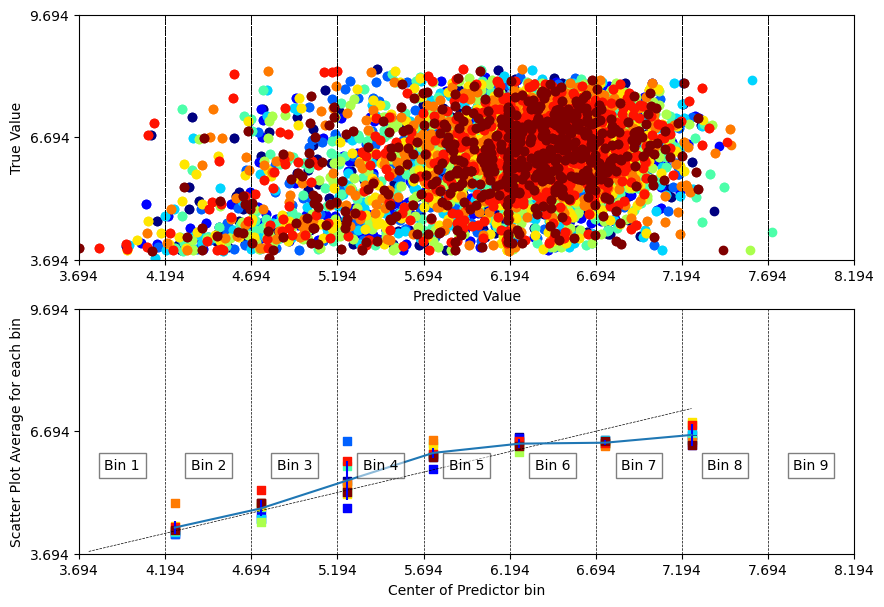

In [6]:
path=r"C:\Users\User\OneDrive - mail.tau.ac.il\Documents\SA_UI\not_used"
cv_num = 10
mean_vec, std_vec, hist_space, x_hist_space, x_ticks, y_ticks, bin_width= SLM_tools.model_eval(tfas_predict_mat, tfas_actually_mat, cv_num, path)

In [7]:
sio.savemat("mean_vec_mu_1.6_3components_new.mat", {'mean_vec': mean_vec})
sio.savemat("std_vec_mu_1.6_3components_new.mat", {'std_vec': std_vec})
sio.savemat("hist_space_mu_1.6_3components_new.mat", {'hist_space': hist_space})
sio.savemat("x_hist_space_mu_1.6_3components_new.mat", {'x_hist_space': x_hist_space})
sio.savemat("x_ticks_mu_1.6_3components_new.mat", {'x_ticks': x_ticks})
sio.savemat("y_ticks_mu_1.6_3components_new.mat", {'y_ticks': y_ticks})

In [8]:
tfas_predict_mat_2, tfas_actually_mat_2, mean_error_mat_2 = SLM_tools.train_again_on_validation_and_test(random_x, validation_index, n_components=3)

In [9]:
sio.savemat("tfas_predict_mat_2_mu_1.6_3components_new.mat", {'tfas_predict_mat_2': tfas_predict_mat_2})
sio.savemat("tfas_actually_mat_2_mu_1.6_3components_new.mat", {'tfas_actually_mat_2': tfas_actually_mat_2})

In [15]:
tfas_predict_mat_2.shape

(1, 526)

In [11]:
tfas_actually_mat_2

array([5.94017125, 7.10578613, 6.12468339, 6.23244802, 7.65112018,
       7.06902343, 6.80017007, 7.04838641, 7.3575562 , 7.19067603,
       7.33888813, 5.66296048, 6.31354805, 6.96034773, 5.84643878,
       7.08170859, 6.41836494, 5.59098698, 4.36944785, 5.3981627 ,
       6.315358  , 6.89871453, 5.49306144, 6.13556489, 6.7129562 ,
       6.51619308, 7.26682735, 7.88720859, 6.52356231, 5.91079664,
       4.40671925, 4.63472899, 7.11314211, 6.38687932, 7.01481435,
       7.08757371, 6.71417053, 6.09130988, 7.46278916, 7.08590146,
       5.92958914, 5.34233425, 5.71042702, 6.44571982, 6.89264164,
       5.1590553 , 6.41017488, 6.64639051, 6.48768402, 6.91968385,
       4.95582706, 6.62671775, 6.53378884, 4.6443909 , 6.48004456,
       5.94017125, 6.96508035, 4.14313473, 8.06840296, 4.69134788,
       6.59578051, 7.34277919, 7.53048   , 5.73334128, 4.82028157,
       4.75359019, 7.22475341, 6.99301512, 7.20637729, 5.170484  ,
       7.53048   , 8.00068478, 5.07517382, 7.27100854, 5.88053

In [ ]:
import os
import numpy as np
from scipy import interpolate
import scipy.io
import Rbeast as rb
from SLM_tools import *
from scipy.io import savemat
import pickle
import re
import time
%matplotlib inline

In [12]:
tfas_predict_mat_2 = sio.loadmat(r"C:\Users\User\OneDrive - mail.tau.ac.il\Documents\SA_UI\not_used\tfas_predict_mat_2_mu_1.6_3components_new.mat")["tfas_predict_mat_2"]
tfas_actually_mat_2 = sio.loadmat(r"C:\Users\User\OneDrive - mail.tau.ac.il\Documents\SA_UI\not_used\tfas_actually_mat_2_mu_1.6_3components_new.mat")["tfas_actually_mat_2"]
mean_vec = sio.loadmat(r"C:\Users\User\OneDrive - mail.tau.ac.il\Documents\SA_UI\not_used\mean_vec_mu_1.6_3components_new.mat")["mean_vec"]
std_vec = sio.loadmat(r"C:\Users\User\OneDrive - mail.tau.ac.il\Documents\SA_UI\not_used\std_vec_mu_1.6_3components_new.mat")["std_vec"]
hist_space = sio.loadmat(r"C:\Users\User\OneDrive - mail.tau.ac.il\Documents\SA_UI\not_used\hist_space_mu_1.6_3components_new.mat")["hist_space"]
x_hist_space = sio.loadmat(r"C:\Users\User\OneDrive - mail.tau.ac.il\Documents\SA_UI\not_used\x_hist_space_mu_1.6_3components_new.mat")["x_hist_space"]
x_ticks = sio.loadmat(r"C:\Users\User\OneDrive - mail.tau.ac.il\Documents\SA_UI\not_used\x_ticks_mu_1.6_3components_new.mat")["x_ticks"]
y_ticks = sio.loadmat(r"C:\Users\User\OneDrive - mail.tau.ac.il\Documents\SA_UI\not_used\y_ticks_mu_1.6_3components_new.mat")["y_ticks"]
path=r"C:\Users\User\OneDrive - mail.tau.ac.il\Documents\SA_UI\not_used"

In [ ]:
tfas_predict_mat_2.shape

In [13]:
SLM_tools.cv_bias_correction(tfas_predict_mat_2=tfas_predict_mat_2, tfas_actually_mat_2=tfas_actually_mat_2, hist_space=hist_space, mean_vec=mean_vec, x_hist_space=x_hist_space,x_ticks=x_ticks,y_ticks=y_ticks,save_path=path)

IndexError: index 130 is out of bounds for axis 0 with size 1